In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nashik-apartment-price-prediction/final_data.csv


In [2]:
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask_apt = df["housetype"] == 'apartment'
    mask_ba = df["house_condition"] == 'old'
    
    low, high = df["total_sqft"].quantile([0.1,0.9])
    mask_area = df["total_sqft"].between(low, high)
    
    df = df[mask_area]
    
    df.drop(columns=["owners", "cordinates","Unnamed: 0"], inplace=True)
    
    return df

In [4]:
df = wrangle("/kaggle/input/nashik-apartment-price-prediction/final_data.csv")
df.head()

,address,housetype,house_condition,BHK,price,per_month_emi,total_sqft,latitude,longitude
0,"Sheetal Vihar, Bhagwant Nagar, Dr.Homi Bhabha ...",Apartment,old,3.0,75.00,39.72,1550.0,19.987960,73.787390
1,"Samraat Dream Citi, Samta Nagar, Nashik",Apartment,old,2.0,41.00,21.71,1000.0,19.982460,73.811840
2,"Suryaprakash Apartment,Nashik Road, Nashik",Apartment,old,2.0,53.35,28.25,970.0,19.975850,73.788750
3,"Adishvar Residency,Nashik Road, Nashik",Apartment,old,2.0,55.00,29.13,1000.0,19.930532,73.811734
4,"Nashik Road, Nashik",Apartment,old,2.0,27.00,14.30,853.0,19.955310,73.840890


In [5]:
print(df.shape)
print(df.info())

(3194, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 3194 entries, 0 to 5479
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          3194 non-null   object 
 1   housetype        3194 non-null   object 
 2   house_condition  3194 non-null   object 
 3   BHK              3164 non-null   float64
 4   price            3194 non-null   float64
 5   per_month_emi    3193 non-null   float64
 6   total_sqft       3194 non-null   float64
 7   latitude         3194 non-null   float64
 8   longitude        3194 non-null   float64
dtypes: float64(6), object(3)
memory usage: 249.5+ KB
None


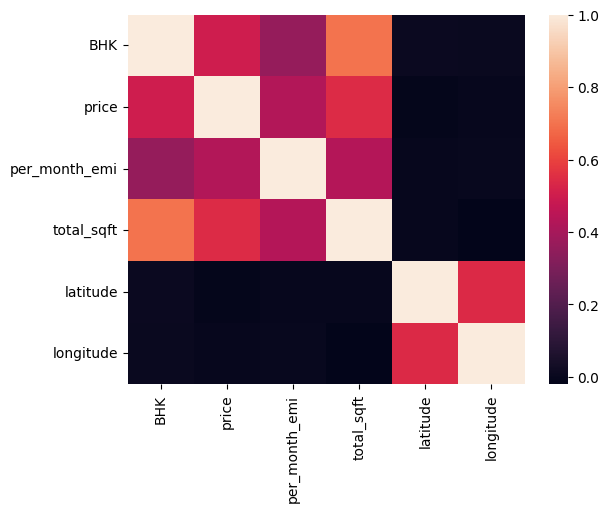

In [6]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr);

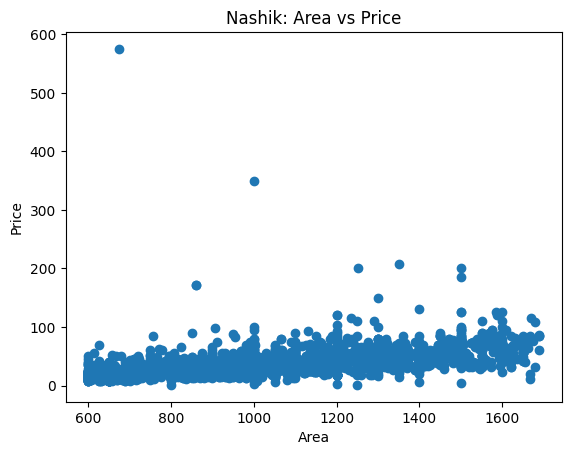

In [7]:
plt.scatter(x=df["total_sqft"], y=df['price'])

plt.xlabel("Area")
plt.ylabel("Price")
plt.title("Nashik: Area vs Price");

Text(0.5, 1.0, 'Distribution of Apartment Price')

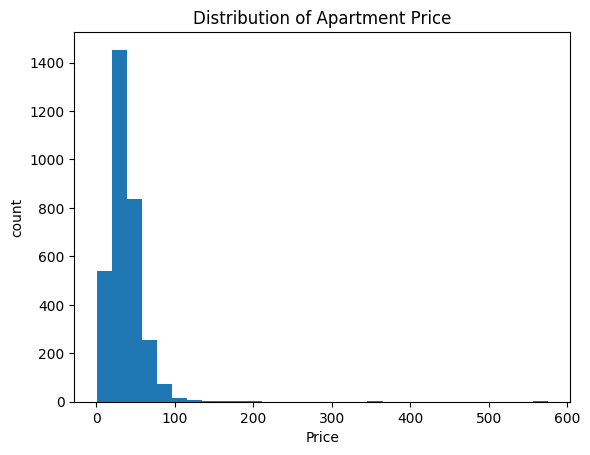

In [8]:
plt.hist(df['price'], bins=30)
plt.xlabel("Price")
plt.ylabel('count')
plt.title("Distribution of Apartment Price")

Text(0.5, 1.0, 'Price vs EMI')

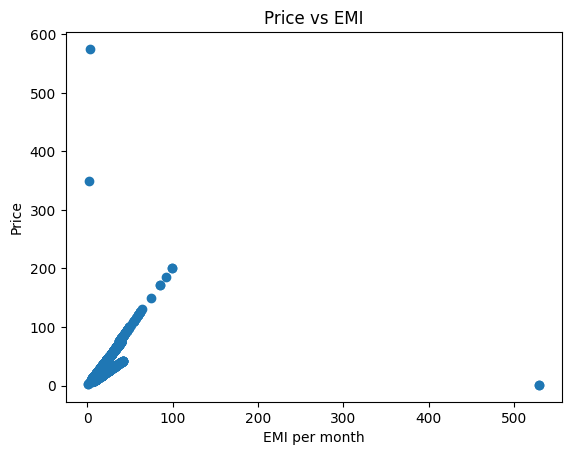

In [9]:
plt.scatter(df['per_month_emi'], df['price'])
plt.xlabel("EMI per month")
plt.ylabel('Price')
plt.title("Price vs EMI")

Text(0.5, 1.0, 'Price vs BHK')

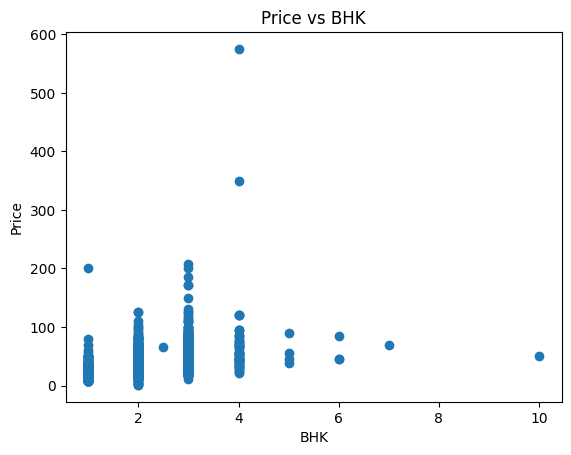

In [10]:
plt.scatter(df['BHK'], df['price'])
plt.xlabel("BHK")
plt.ylabel('Price')
plt.title("Price vs BHK")

In [11]:
# split
target = "price"
features = ["total_sqft", "latitude", "longitude", "per_month_emi", "BHK"]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


In [12]:
# Build Base line model
y_mean = y_train.mean()
print("mean_apt_price: ", y_mean)
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline MAE: ", baseline_mae)

mean_apt_price:  37.40149119373777
Baseline MAE:  14.224487822886708


In [13]:
# iterate
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [14]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    50.925860
1    26.439755
2    46.233945
3    36.723293
4    30.509078
dtype: float64

In [15]:
# communicate
intercept = model.named_steps["ridge"].intercept_
coefficient = model.named_steps['ridge'].coef_
print(intercept)
print(coefficient)

1.8874265430752644
[ 0.02111944 -0.96797905  0.15463905  0.43918153  6.27090209]


In [16]:
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficient, index=features)
feat_imp

/opt/conda/lib/python3.10/site-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


total_sqft       0.021119
latitude        -0.967979
longitude        0.154639
per_month_emi    0.439182
BHK              6.270902
dtype: float64

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

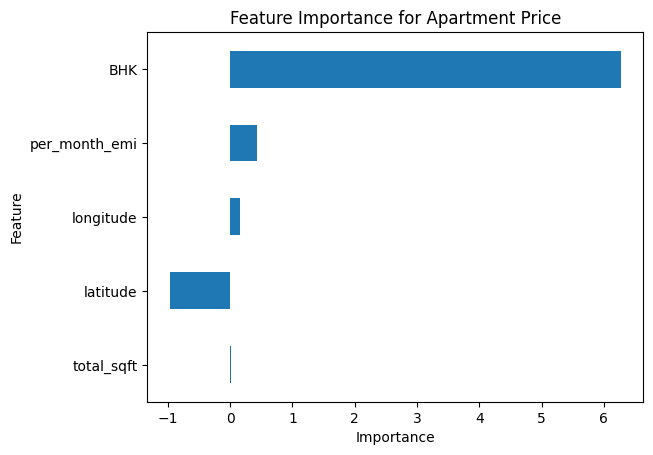

In [17]:
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")